In [ ]:
!conda install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.model_code.fix_point_alg import calc_fixp
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.estimation.estimation_transitions import create_transition_matrix

## Simulation tutorial

This notebook provides a tutorial of how to use ruspy's simulation function ``simulate``. Furthermore, the convergence of expected utility calculated by fixed point algorithm and the observed utility on the simulated data are demonstrated.

First we specify the initialization dictionairy for the simulation.

In [ ]:
# Set simulating variables
disc_fac = 0.9999
num_buses = 100
num_periods = 80000
gridsize = 1000
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762, 2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])
scale = 1e-3

init_dict = {
    "simulation": {
        "discount_factor": disc_fac,
        "periods": num_periods,
        "seed": 123,
        "buses": num_buses,
    },
    "plot": {"gridsize": gridsize},
}

Beside the initializsation dictionary, the ``simulate`` function takes other inputs. These objects are calculated below and are passed to the simulation function, which returns the simulated data.

In [ ]:
# Calculate objects necessary for the simulation process. See documentation for details.
num_states = 200
costs = calc_obs_costs(num_states, lin_cost, params, scale)

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(trans_mat, costs, disc_fac)[0]

In [ ]:
# Simulate the data.
df = simulate(init_dict["simulation"], ev, costs, trans_mat)

In the following, a exercise is provided, which shows the convergence of expected utility calculated by fixed point algorithm and the observed utility on the simulated data.

In [ ]:
# Provide a discounting function.
def discount_utility(df, max_period, disc_fac):
    v = 0.0
    for i in df.index.levels[0]:
        v += np.sum(
            np.multiply(
                disc_fac ** np.arange(max_period),
                df.xs([i]).loc[: max_period - 1, "utilities"],
            )
        )
    return v / len(df.index.levels[0])

In [ ]:
# Discount the utility of the observed data
num_points = int(num_periods / gridsize) + 1

periods = np.arange(0, num_periods + gridsize, gridsize)

v_disc = np.zeros_like(periods)
for i, period in enumerate(periods[1:]):
    v_disc[i + 1] = discount_utility(df, period, disc_fac)

In [ ]:
# Create an array containing the expected long-run performance.
v_exp = np.full(num_points, ev[0])

The results are now visualized in oder to show convergence of the observed utility on the simulated data to the expected utility by the fixed point algorithm.

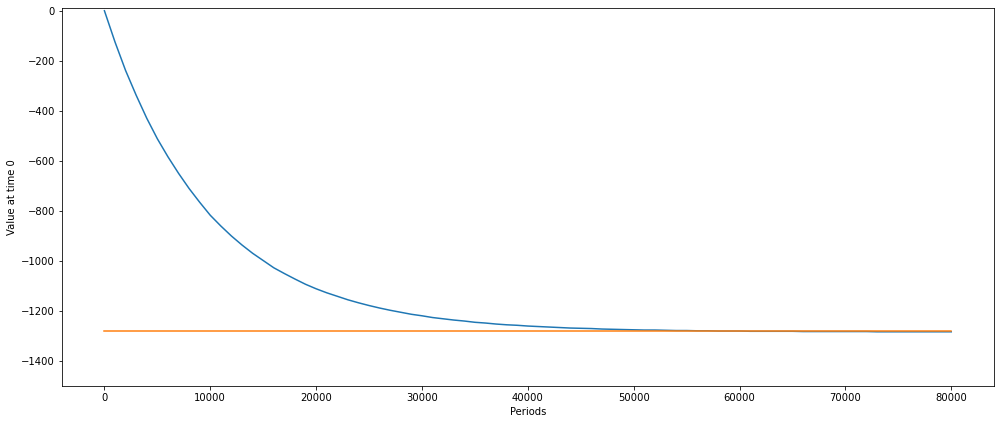

In [9]:
ax = plt.figure(figsize=(14, 6))

ax1 = ax.add_subplot(111)

ax1.set_ylim([-1500, 10])

ax1.set_ylabel(r"Value at time 0")
ax1.set_xlabel(r"Periods")

ax1.plot(periods, v_disc, color="#1f77b4", label="observed performance")
ax1.plot(periods, v_exp, color="#ff7f0e", label="long-run perfomance")

plt.tight_layout()

plt.savefig("figure_1.png", dpi=300)